In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

In [2]:
path_inception = f"{getcwd()}/temp2/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = path_inception

pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False
  # Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization_v1[0][0]     
_______________________________________________________________________________________

In [6]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [7]:
# Define a Callback class that stops training once accuracy reaches 97.0%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.90):
      print("\nReached 90.0% accuracy so cancelling training!")
      self.model.stop_training = True


In [8]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (7, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization_v1[0][0]     
______________________________________________________________________________________________

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'temp2/images/train'
validation_dir = 'temp2/images/validation'

# Create an ImageDataGenerator and do Image Augmentation
train_datagen = ImageDataGenerator(
    # Your Code Here
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150))



Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [12]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 97% accuracy

callbacks = myCallback()
history = model.fit_generator(train_generator,
                            validation_data = validation_generator,
                            steps_per_epoch = 100,
                            epochs = 10,
                            validation_steps = 50,
                            verbose = 2,
                            callbacks=[callbacks])

Epoch 1/10
100/100 - 358s - loss: 1.7358 - acc: 0.3241 - val_loss: 2.0859 - val_acc: 0.3780
Epoch 2/10
100/100 - 318s - loss: 1.6799 - acc: 0.3500 - val_loss: 2.2597 - val_acc: 0.3950
Epoch 3/10
100/100 - 289s - loss: 1.7000 - acc: 0.3550 - val_loss: 2.2585 - val_acc: 0.3160
Epoch 4/10
100/100 - 297s - loss: 1.6747 - acc: 0.3560 - val_loss: 2.2945 - val_acc: 0.3990
Epoch 5/10
100/100 - 282s - loss: 1.6662 - acc: 0.3605 - val_loss: 2.2333 - val_acc: 0.3750
Epoch 6/10
100/100 - 286s - loss: 1.6412 - acc: 0.3635 - val_loss: 2.2823 - val_acc: 0.4040
Epoch 7/10
100/100 - 294s - loss: 1.6655 - acc: 0.3640 - val_loss: 2.5240 - val_acc: 0.3720
Epoch 8/10
100/100 - 306s - loss: 1.6313 - acc: 0.3935 - val_loss: 2.4517 - val_acc: 0.3600
Epoch 9/10
100/100 - 319s - loss: 1.6524 - acc: 0.3830 - val_loss: 2.5477 - val_acc: 0.3930
Epoch 10/10
100/100 - 342s - loss: 1.6521 - acc: 0.3635 - val_loss: 2.2729 - val_acc: 0.4040


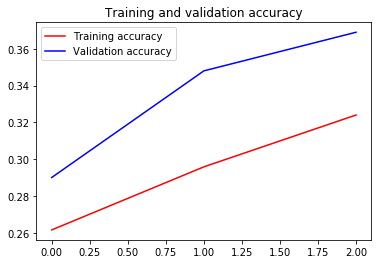

<Figure size 432x288 with 0 Axes>

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()